The aim of this notebook is to improve on the previous Candlestick Study notebooks and demonstrate how to run the analysis faster through building Custom Factors. This notebook is designed to be implemented in Quantopian's research environment with Pipeline. More commentary on the code can be found on AAAQuant's Candlestick Pattern Study blog at aaaquants.com.

In [232]:
import talib
import numpy as np
from numpy import nan, isnan
from matplotlib.pyplot import plot,show,subplots,legend,boxplot
import pandas as pd
from quantopian.pipeline.factors.morningstar import MarketCap
from quantopian.pipeline import Pipeline, CustomFactor
from quantopian.research import run_pipeline
from quantopian.pipeline import CustomFactor
from quantopian.pipeline.data.builtin import USEquityPricing as USEP
import seaborn as sns
import matplotlib.pyplot as plt
import heapq
from quantopian.pipeline.filters import Q500US
from quantopian.pipeline.factors.morningstar import MarketCap


In [824]:
def columnwise_anynan(array2d):
    # isnan will be broadcasted over the array to produce a 2D array of bools.
    # array.any(axis=0) gives us a 1D array whose length is equal to the
    # number of columns in the array.
    return isnan(array2d).any(axis=0)


class cdl_indicator(CustomFactor):
    inputs = [USEP.open, USEP.high, USEP.low, USEP.close]
    window_length = 30
    
    def compute(self, today, assets, out, open, high, low, close):
        """
        Compute WILLR on each column of high, low, and close.
        """
        # Assume that a nan in high implies a nan in low or close.
        # If we had datasets from different sources, we'd probably
        # want to do something like:
        # columnwise_anynan(high) | columnwise_anynan(low) | columnwise_anynan(close).
        anynan = columnwise_anynan(high)
        
        # In general, it's a bad practice to iterate over numpy arrays like this in pure
        # python. Unfortunately, TALib doesn't provide us with an API to vectorize
        # operations over 2D arrays, so we're stuck with doing this.
        # A nice improvement to Zipline would be to provide a module that does this 
        # efficiently in Cython.
        for col_ix, have_nans in enumerate(anynan):
            
            # If we have nans in the input (e.g., because an asset didn't trade for a 
            # full day, or because the asset hasn't existed for 14 days), just forward
            # the NaN.
            if have_nans:
                out[col_ix] = nan
                continue 
            
            # Compute our actual WILLR value.
            # The [:, ix] syntax here is telling Numpy to slice along the second dimension.
            # Just doing array[ix] would give us rows instead of columns
            results = talib.CDLUNIQUE3RIVER(
                open[:, col_ix],
                high[:, col_ix], 
                low[:, col_ix], 
                close[:, col_ix], 
            )
            
            # Results is a length 14 array containing 13 leading NaNs and then the actual value
            # we care about.  Needless to say, this is less efficient than it could be.
            out[col_ix] = results[-4]/100.
            
            
class close_Price(CustomFactor):  
    # Define inputs
    inputs = [USEquityPricing.close]
    window_length = 4
    
    def compute(self, today, assets, out, close):  
        out[:] = close[-4]
            
class forward_return3(CustomFactor):
    inputs = [USEquityPricing.close]
    window_length = 4
    
    def compute(self, today, assets, out, close):
        out[:] = ((close[-1] - close[-4])/close[-4]) * 100   #[0] is furthest away 


class forward_return2(CustomFactor):
    inputs = [USEquityPricing.close]
    window_length = 4
    
    def compute(self, today, assets, out, close):
        out[:] = ((close[-2] - close[-4])/close[-4]) * 100
            
class forward_return1(CustomFactor):
    inputs = [USEquityPricing.close]
    window_length = 4
    
    def compute(self, today, assets, out, close):
        out[:] = ((close[-3] - close[-4])/close[-4]) * 100


def make_pipeline():
       
    sig = cdl_indicator()
    price = close_Price()
    fwdReturn3 = forward_return3()
    fwdReturn2 = forward_return2()
    fwdReturn1 = forward_return1()
    
    
    return Pipeline(
        columns={
            'sig': sig,
            'price': price,
            'FwdReturn3': fwdReturn3,
            'FwdReturn2': fwdReturn2,
            'FwdReturn1': fwdReturn1
        },
        screen=Q500US()
        #screen=myMktCap
    )         

In [857]:
d1 = '2016-06-01'
d2 = '2017-12-31'
def pipeline_output(d1,d2):
    pipe = make_pipeline()
    myPipe = run_pipeline(pipe, start_date=d1, end_date=d2)
    
    return myPipe

In [858]:
myPipe = pipeline_output(d1,d2)

In [859]:
assert(len(myPipe[myPipe['sig']!=0]>1))

In [860]:
myPipe = myPipe.fillna(0)

In [861]:
periodList = [1,2,3]

In [862]:
def calc_pnl(priceRets, periodList):
    '''Calculates pnl by multiplying the fwd return and the signal for each period in periodList'''
    for period in periodList:
        priceRets['PnL%s'%period] = priceRets['FwdReturn%s'%period]*priceRets['sig']
        
    return priceRets

In [863]:
def check_signal_direction(priceRets, periodList):
    '''Makes list of checking if signal direction matches fwd returns'''
    '''+1 means signal correlated with return, -1 means signal is not correlated'''
    
    for period in periodList:
        sigList = [0 if sig == 0 else 1 if np.sign(sig) == np.sign(priceRets['FwdReturn%s'%period][i]) else -1 for i,sig in enumerate(priceRets['sig'])]
        priceRets['Match%s'%period] = sigList
    
    return priceRets

In [864]:
myPipe = calc_pnl(myPipe,periodList)
myPipe = check_signal_direction(myPipe,periodList)

In [865]:
def win_loss_ratio(priceRets,period):
    '''Calculates win loss ratio based on number of good matches over sum of good and bad matches'''
    goodMatch = float(len(priceRets[priceRets['Match%s'%period]==1]))
    badMatch = float(len(priceRets[priceRets['Match%s'%period]==-1]))
    
    if (goodMatch+badMatch) != 0.0:
        winLossRatio = goodMatch/(goodMatch+badMatch)
    else:
        winLossRatio = 0.0
    
    return winLossRatio

In [866]:
def all_win_loss_ratios(priceRets,periodList):
    '''Adds win loss ratios to list for each period in user specified period list'''
    '''Calls above function'''
    winLossRatios = []
    for period in periodList:
        winLossRatio = win_loss_ratio(priceRets,period)
        winLossRatios.append(winLossRatio)
        
    return winLossRatios

In [867]:
def scaled_win_loss_ratio(priceRets,period):
    '''Calculates win loss ratio but scaled by multiplying pnl'''
    '''We can make sure the returns made with correct predictions outweigh'''
    goodPnL = np.sum(priceRets[priceRets['Match%s'%period]==1]['PnL%s'%period])
    badPnL = abs(np.sum(priceRets[priceRets['Match%s'%period]==-1]['PnL%s'%period]))
    
    if (goodPnL+badPnL) != 0.0:
        scaledWinLossRatio = goodPnL/(goodPnL+badPnL)
    else:
        scaledWinLossRatio = 0.0
    
    return scaledWinLossRatio

In [868]:
def all_scaled_win_loss_ratios(priceRets,periodList):
    '''Adds scaled win loss ratios to list for each period in user specified period list'''
    scaledWinLossRatios = []
    for period in periodList:
        scaledWinLossRatio = scaled_win_loss_ratio(priceRets,period)
        scaledWinLossRatios.append(scaledWinLossRatio)
    
    return scaledWinLossRatios

In [869]:
def sum_pos(x,tradeSign):
    '''Returns number of pos/neg signals for a certain date'''
    sums = 0
    for y in x: 
        if y == tradeSign:
            sums = sums + 1
    return sums

In [870]:
def longs_shorts_sum(priceRets):
    longs = priceRets['sig'].groupby(priceRets.index.get_level_values(0)).apply(lambda x: sum_pos(x,1))
    shorts = priceRets['sig'].groupby(priceRets.index.get_level_values(0)).apply(lambda x: sum_pos(x,-1))
    
    return longs,shorts

In [871]:
def pos_count(abc,period):
    '''Counts long/short positions for each date taking into account exited positions from period minutes ago'''
    xyz = abc.shift(period).fillna(0)
    
    prevPosCount = 0
    posCounts = []
    abcxyz = zip(abc,xyz)
    
    for v in abcxyz:
        posCount = v[0] + prevPosCount - v[1]
        posCounts.append(posCount)
        
        prevPosCount = posCount
        
    return np.array(posCounts)

In [872]:
def max_pos(priceRets,period):
    '''We find the 10th highest number of long positions at any one time that we hold to divide returns with'''
    longs,shorts = longs_shorts_sum(priceRets)
    longPosCount = pos_count(longs,period)
    shortPosCount = pos_count(shorts,period)
    netPosCount = longPosCount - shortPosCount
    maxNetPos = int(0.8*max(netPosCount))  #sometimes we will be overleveraged
    
    return maxNetPos,netPosCount

In [873]:
def mean_pnl(priceRets,period):
    
    priceRets['PnL%s'%period] = priceRets['PnL%s'%period].fillna(0)
    maxNetPos,netPosCount = max_pos(priceRets,period)
    
    meanPnL = priceRets['PnL%s'%period].groupby(priceRets.index.get_level_values(0)).apply(lambda x: np.sum(x))/float(maxNetPos)
    meanPnL = meanPnL.replace(np.inf, 0)
    meanPnL = meanPnL.replace(-np.inf,0)
    
    return meanPnL

In [874]:
def net_pnl(priceRets,period):
    '''Calculates net pnl'''
    meanPnL = mean_pnl(priceRets,period)
    netMeanPnL = np.sum(meanPnL)
    
    return netMeanPnL

In [875]:
def all_net_pnls(priceRets,periodList):
    '''Adds net pnls to list for each period in user specified period list'''
    netPnLs = []
    for period in periodList:
        netPnL = net_pnl(priceRets,period)
        netPnLs.append(netPnL)
    
    return netPnLs

In [876]:
def metrics(priceRets,periodList):
    winLossRatios = all_win_loss_ratios(priceRets,periodList)
    scaledWinLossRatios = all_scaled_win_loss_ratios(priceRets,periodList)
    netPnLs = all_net_pnls(priceRets,periodList)
    
    return winLossRatios, scaledWinLossRatios, netPnLs

In [877]:
winLossRatios,scaledWinLossRatios,netPnLs = metrics(myPipe,periodList)

In [878]:
def prep_visuals(visualDf1,priceRets,period):
    visualDf1['meanPnL%s'%period] = mean_pnl(priceRets,period).fillna(0)
    
    return visualDf1

In [879]:
visualDf1 = pd.DataFrame()
for period in periodList:
    visualDf1 = prep_visuals(visualDf1,myPipe,period)

In [880]:
def metrics_per_trade(priceRets,periodList,visualDf1):
    numTrades = len(priceRets.dropna()[priceRets.dropna()['sig']!=0])
    avgPnLs = []
    
    for period in periodList:
        if numTrades != 0:
            avgPnL = np.sum(visualDf1['meanPnL%s'%period])/numTrades
        else:
            avgPnL = 0
        avgPnLs.append(avgPnL)

    avgPnLs = pd.Series(avgPnLs,index=periodList)
   
    return avgPnLs, numTrades

In [881]:
avgPnLs,numTrades = metrics_per_trade(myPipe,periodList,visualDf1)

In [882]:
avgPnLs,numTrades

(1    0.022212
 2    0.049263
 3    0.037335
 dtype: float64, 298)

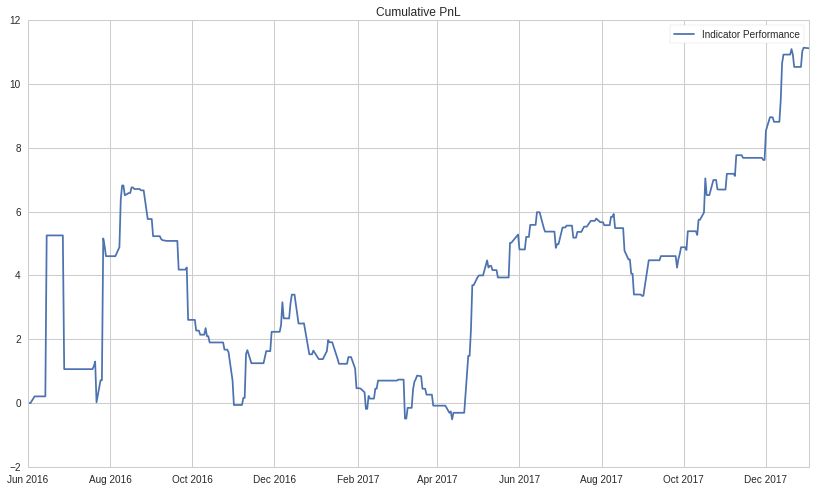

In [883]:
plt.plot(np.cumsum(visualDf1['meanPnL3']),label='Indicator Performance')
plt.title('Cumulative PnL')
plt.legend()
plt.show()

In [853]:
from pandas.tseries.offsets import BDay
visualDf1.index = visualDf1.index - BDay(4)

In [854]:
stdDay1 = visualDf1['meanPnL1'].groupby((visualDf1.index.unique()).dayofweek).std()
stdDay2 = visualDf1['meanPnL2'].groupby((visualDf1.index.unique()).dayofweek).std()
stdDay3 = visualDf1['meanPnL3'].groupby((visualDf1.index.unique()).dayofweek).std()
dayDict = {0:'Mon',1:'Tue',2:'Wed',3:'Thurs',4:'Fri'}
stdDay1.index = [dayDict[stdDay1.index[i]] for i in stdDay1.index]

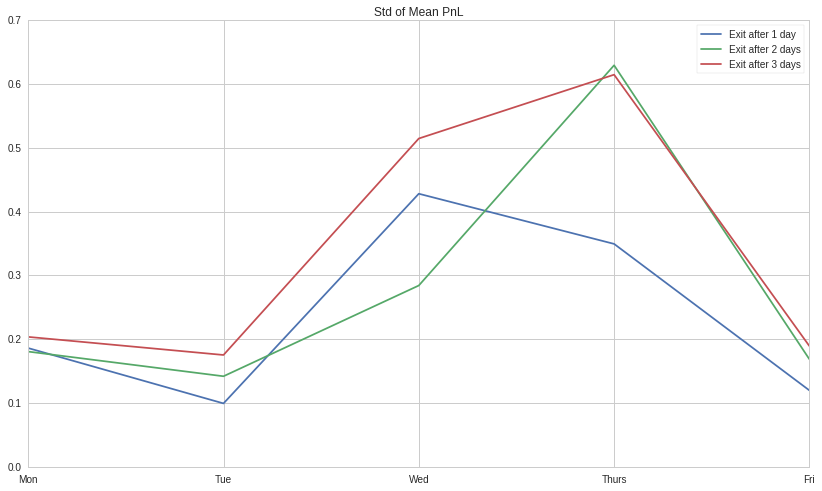

In [856]:
plt.plot(stdDay1.values,label='Exit after 1 day')
plt.plot(stdDay2.values,label='Exit after 2 days')
plt.plot(stdDay3.values,label='Exit after 3 days')
x = [0,1,2,3,4]
plt.xticks(x, stdDay1.index)
plt.title('Std of Mean PnL')
plt.legend();